***Задание 4 из ДЗ 5. * (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.***

In [14]:
import numpy as np

In [15]:
# Расчет критерия Джини

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    e = 0
    for label in classes:
        p = classes[label] / len(labels)
        e += p * np.log2(p)
    e = -e
        
    return e

In [16]:
# Проверим на примере из методички
blue = 9
yellow = 11
total = blue + yellow

p_blue = blue / total
p_yellow = yellow / total
p_blue, p_yellow

(0.45, 0.55)

In [17]:
e0 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e0

0.9927744539878083

In [18]:
labels = ["b" for _ in range(9)]
for i in range(11):
    labels.append("y")
print(entropy(labels))

0.9927744539878083


***ДЗ к 6 уроку.     1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.***

In [54]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [55]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [56]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [57]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [58]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [59]:
def residual(y, z):
    return - (z - y)

In [60]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [88]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

In [98]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):                             
    train_prediction = gb_predict(X_train, trees, eta)
    
    mse_train = mean_squared_error(y_train, train_prediction)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse_train}')

    test_prediction = gb_predict(X_test, trees, eta)
    
    mse_test = mean_squared_error(y_test, test_prediction)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse_test}')
    
           

In [101]:
# создадим списки, в которые будем помещать max_depth и значения ошибки алгоритма для train и test

list_max_depth = [[], [], []]

In [96]:
def add_data(new_list, param, mse_train, mse_test):
    new_list[0].append(param)
    new_list[1].append(mse_train)
    new_list[2].append(mse_test)
    return new_list

In [123]:
# Увеличим число деревьев в ансамбле до 100, максимальная глубина деревьев пока останется неизменной, шаг тот же (0.1)

n_trees = 100
trees_1, train_errors_1, test_errors_1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_1, eta)


Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 916.2185634144981
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3025.5730970824097


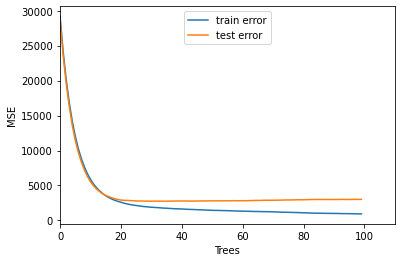

In [124]:
# графики зависимости ошибки на обучающей и тестовой выборках от количества деревьев (eta = 0.1, max_depth = 3)

plt.xlabel('Trees')
plt.ylabel('MSE')
plt.xlim(0, 110)
plt.plot(list(range(n_trees)), train_errors_1, label='train error')
plt.plot(list(range(n_trees)), test_errors_1, label='test error')
plt.legend(loc='upper center')
plt.show()

In [104]:
def evaluate_alg_2(X_train, X_test, y_train, y_test, trees, eta):                             
    train_prediction = gb_predict(X_train, trees, eta)
    
    mse_train = mean_squared_error(y_train, train_prediction)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse_train}')

    test_prediction = gb_predict(X_test, trees, eta)
    
    mse_test = mean_squared_error(y_test, test_prediction)
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse_test}')
    
    return max_depth, mse_train, mse_test        # теперь функция возвращает max_depth, mse_train, mse_test 

In [105]:
# Теперь меняем максимальную глубину деревьев, число деревьев в ансамбле остается неизменным (30), шаг тот же

n_trees = 30
for i in range(1, 11):
    max_depth = i
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    m, mse_train, mse_test = evaluate_alg_2(X_train, X_test, y_train, y_test, trees, eta)
    add_data(list_max_depth, max_depth, mse_train, mse_test)
    
    
""" Результат:
Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 3176.938511020303
Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2694.412416683353
Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2563.1969302140865
Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2498.5844372683537
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1890.3870016572628
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2750.4985562809634
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1239.9410313541475
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 2844.042055074898
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 682.4194195496332
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3417.832439238299
Ошибка алгоритма из 30 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 323.2911493787881
Ошибка алгоритма из 30 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 3488.566749612746
Ошибка алгоритма из 30 деревьев глубиной 7     с шагом 0.1 на тренировочной выборке: 174.5236411424473
Ошибка алгоритма из 30 деревьев глубиной 7     с шагом 0.1 на тестовой выборке: 3874.707041825176
Ошибка алгоритма из 30 деревьев глубиной 8     с шагом 0.1 на тренировочной выборке: 119.60849205896258
Ошибка алгоритма из 30 деревьев глубиной 8     с шагом 0.1 на тестовой выборке: 4295.258106572508
Ошибка алгоритма из 30 деревьев глубиной 9     с шагом 0.1 на тренировочной выборке: 81.6858261275711
Ошибка алгоритма из 30 деревьев глубиной 9     с шагом 0.1 на тестовой выборке: 4594.370992070948
Ошибка алгоритма из 30 деревьев глубиной 10     с шагом 0.1 на тренировочной выборке: 65.09621782346986
Ошибка алгоритма из 30 деревьев глубиной 10     с шагом 0.1 на тестовой выборке: 5017.0910960988695
"""

Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 3176.938511020303
Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2694.412416683353
Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2563.1969302140865
Ошибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2498.5844372683537
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1890.3870016572628
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2750.4985562809634
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1239.9410313541475
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 2844.042055074898
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 682.4194195496332
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3417.832

' Результат:\nОшибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тренировочной выборке: 3176.938511020303\nОшибка алгоритма из 30 деревьев глубиной 1     с шагом 0.1 на тестовой выборке: 2694.412416683353\nОшибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2563.1969302140865\nОшибка алгоритма из 30 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 2498.5844372683537\nОшибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1890.3870016572628\nОшибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2750.4985562809634\nОшибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 1239.9410313541475\nОшибка алгоритма из 30 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 2844.042055074898\nОшибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 682.4194195496332\nОшибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тес

Теперь построим графики зависимости ошибки на обучающей и тестовой выборках от максимальной глубины.

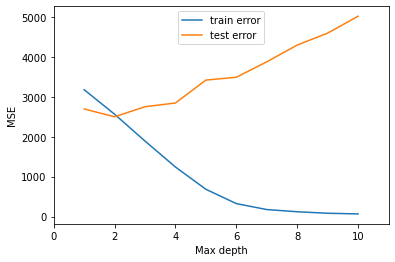

In [107]:
# графики зависимости ошибки на обучающей и тестовой выборках от max_depth (eta = 0.1, tree number = 40)

plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.xlim(0, 11)
plt.plot(list_max_depth[0], list_max_depth[1], label='train error')
plt.plot(list_max_depth[0], list_max_depth[2], label='test error')
plt.legend(loc='upper center')
plt.show()

Вывод: как видно из первого графика, при увеличении максимального количества деревьев сначала происходит значительное снижение ошибки как на тренировочной, так и на тестовой выборках. Когда число деревьев начинает превышать 30, ошибка на тестовой выборке начинает возрастать, в то время как ошибка на тренировочной выборке снижается - происходит переобучение.
При изменении максимальной глубины деревьев наблюдаем похожую картину, но с более резким увеличением ошибки на тестовой выборке, когда максимальная глубина превышает значение 2. При этом ошибка на тренировочной выборке снижается - здесь тоже происходит переобучение.

**** 2. Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.***

In [129]:

def gb_fit_2(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # генерируем случайные индексы объектов выборки 
        train_ind = random.sample(range(0, X_train.shape[0]), X_train.shape[0] // 2)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[train_ind, :], y_train[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[train_ind, :], residual(y_train, target)[train_ind])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [130]:
n_trees, max_depth = 100, 3
trees_2, train_errors_2, test_errors_2 = gb_fit_2(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_2, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 953.2342336229963
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3009.416249195723


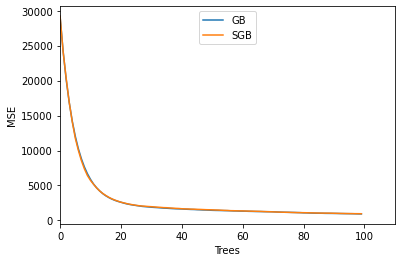

In [132]:
# графики зависимости ошибки на тестовой выборке от количества итераций (eta = 0.1, max_depth = 3, n_trees = 100)

plt.xlabel('Trees')
plt.ylabel('MSE')
plt.xlim(0, 110)
plt.plot(list(range(n_trees)), train_errors_1, label='GB')
plt.plot(list(range(n_trees)), train_errors_2, label='SGB')
plt.legend(loc='upper center')
plt.show()